## Welcome to the `deeplabv3+ Starter` Workshop!
In this workshop, we'll learn the concept of how to use deeplabv3+ model (involving Atrous convolutions, Atrous Spatial Pyramid Pooling, Decoder) for Semantic Segmentation using Pytorch. We'll do the following tasks:

- **Dataset** : Download and use BDD100k dataset
- **Network** : Define deeplabv3+ model using resnet50, Atrous convolutions, ASPP modules, Decoder
- **Training** : Train and validate model on the custom dataset
- **Evaluate** : Evaluate the model on Test Data and visualize results

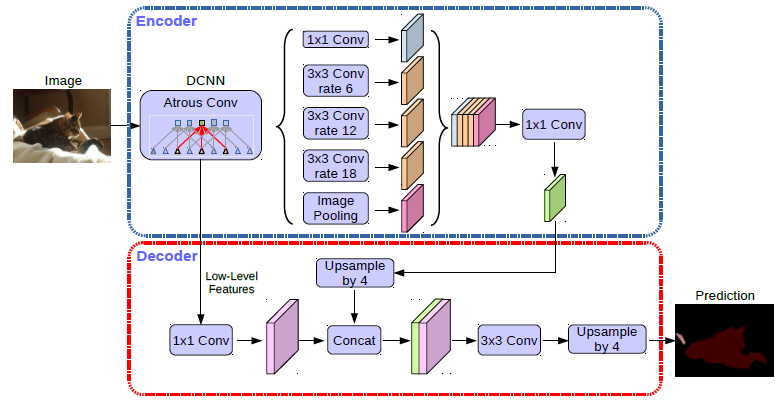

[Image reference](https://arxiv.org/pdf/1802.02611.pdf)

In [1]:
import sys
import os

# Add the path to the utils folder
sys.path.append(os.path.abspath('../utils'))


## Imports

In [2]:
# basic imports
import numpy as np

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# libraries for loading image, plotting
import cv2
import matplotlib.pyplot as plt

In [3]:
try:
    import segmentation_models_pytorch as smp
except:
    !pip install segmentation-models-pytorch
    import segmentation_models_pytorch as smp

## 1. Dataset : Download and use BDD100k dataset

In [4]:
output_path = '../weights'
# load images and label data
images = np.load("./../dataset/bdd_image_180_320.npy")
labels = np.load("./../dataset/bdd_label_180_320.npy")

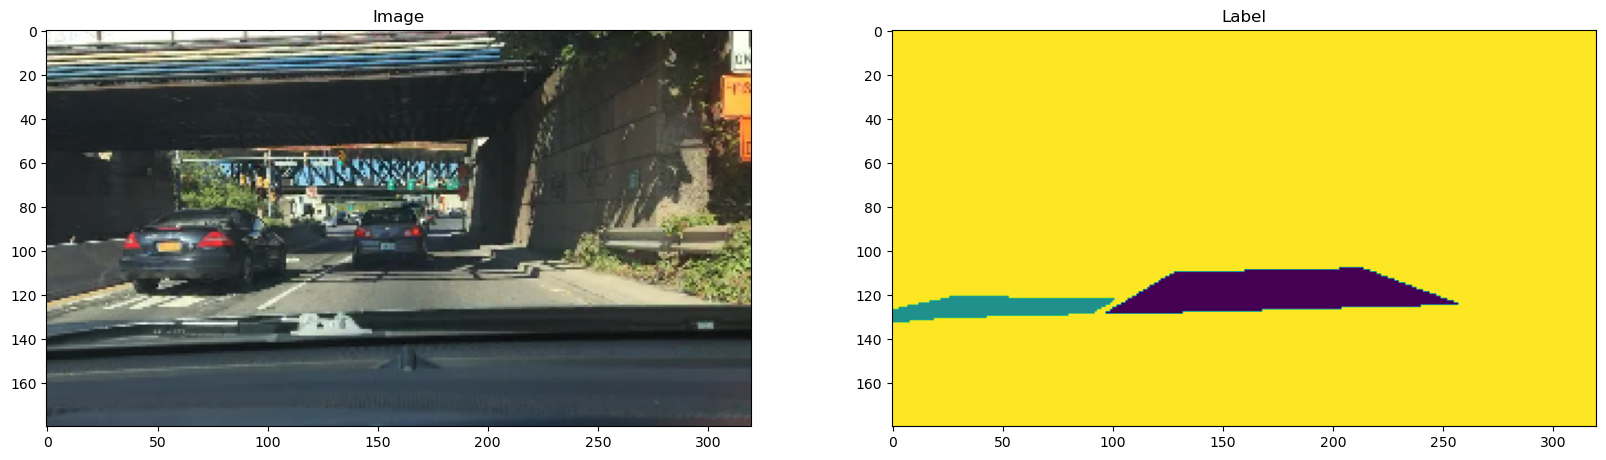

In [5]:
f, (ax0, ax1) = plt.subplots(1,2, figsize=(20,40))
idx=316
ax0.imshow(images[idx])
ax0.set_title("Image")
ax1.imshow(labels[idx])
ax1.set_title("Label")
plt.show()

### Build Datasets & DataLoaders
Every PyTorch model is built and train using 3 elements:

*   Dataset
*   DataLoader
*   Model


In [6]:
# utility functions to get BDD100k Pytorch dataset and dataloaders
from utils import get_datasets, get_dataloaders

train_set, val_set, test_set= get_datasets(images, labels)
sample_image, sample_label = train_set[0]
print(f"There are {len(train_set)} train images, {len(val_set)} validation images, {len(test_set)} test Images")
print(f"Input shape = {sample_image.shape}, output label shape = {sample_label.shape}")

train_dataloader, val_dataloader, test_dataloader = get_dataloaders(train_set, val_set, test_set)

There are 2401 train images, 686 validation images, 343 test Images
Input shape = torch.Size([3, 180, 320]), output label shape = torch.Size([180, 320])


### Show Sample images from dataset

In [7]:
from collections import namedtuple

# Each label is a tuple with name, class id and color
Label = namedtuple( "Label", [ "name", "train_id", "color"])
drivables = [
             Label("direct", 0, (32, 146, 190)),        # red
             Label("alternative", 1, (119, 231, 124)),  # cyan
             Label("background", 2, (0, 0, 0)),        # black
            ]

train_id_to_color = [c.color for c in drivables if (c.train_id != -1 and c.train_id != 255)]
train_id_to_color = np.array(train_id_to_color)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


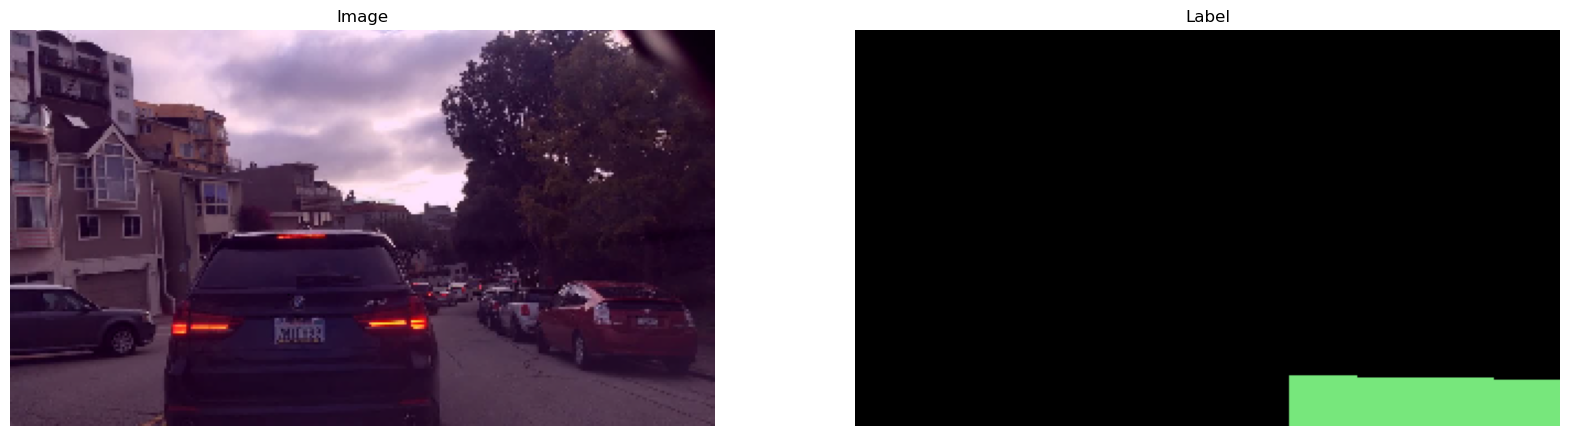

In [8]:
from utils import inverse_transform#, train_id_to_color

rgb_image, label = train_set[np.random.choice(len(train_set))]
rgb_image = inverse_transform(rgb_image).permute(1, 2, 0).cpu().detach().numpy()
label = label.cpu().detach().numpy()

# plot sample image
fig, axes = plt.subplots(1,2, figsize=(20,10))
axes[0].imshow(rgb_image);
axes[0].set_title("Image");
axes[0].axis('off');
axes[1].imshow(train_id_to_color[label]);
axes[1].set_title("Label");
axes[1].axis('off');

## 2. Network
Define deeplabv3+ model using resnet50, Atrous convolutions, ASPP modules, Decoder

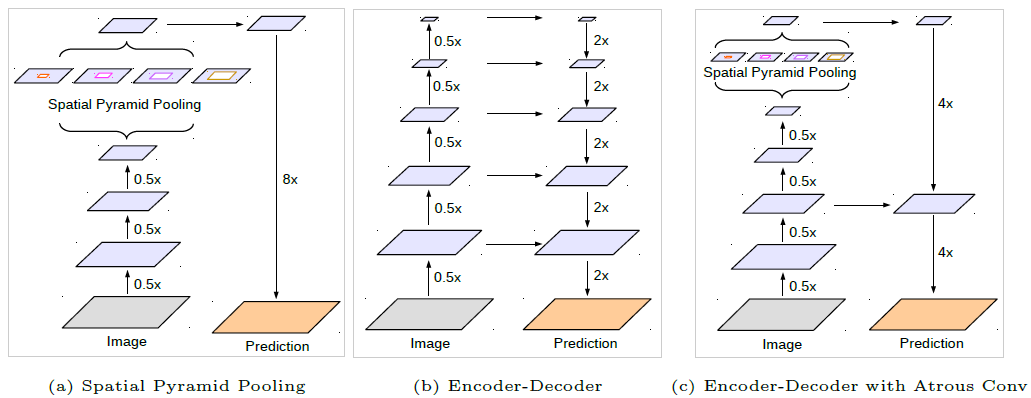

[Image reference](https://arxiv.org/pdf/1802.02611)

In [9]:
class aspp_conv(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rate):
        super(aspp_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, dilation=dilation_rate, padding=dilation_rate, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        return self.conv(x)

In [10]:
class aspp_pool(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(aspp_pool, self).__init__()
        self.pooling_module = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU())

    def forward(self, x):
        input_size = x.shape[-2:]
        x = self.pooling_module(x)
        return F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)

In [11]:
class atrous_spatial_pyramid_pooling(nn.Module):
    def __init__(self, in_channels, out_channels, dilation_rates):
        super(atrous_spatial_pyramid_pooling, self).__init__()

        layers = nn.ModuleList([])

        # skip-connection, match the output channels
        # using 1x1 convolutions
        layers.append(nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ))

        # spatial pyramid pooling wiht atrous convolutions
        for rate in dilation_rates:
            layers.append(aspp_conv(in_channels, out_channels, rate))

        # image pooling layer
        layers.append(aspp_pool(in_channels, out_channels))

        # create Pytorch module list
        self.layers = nn.ModuleList(layers)

        # 1x1 convolution to project concatenated output
        # to desired number of channels
        self.project = nn.Sequential(
            nn.Conv2d(len(layers) * out_channels, out_channels, kernel_size=1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        conv_outputs = []
        for mod in self.layers:
            mod_output = mod(x)
            conv_outputs.append(mod_output)

        # concatenate output and reduce num_channels
        output = self.project(torch.cat(conv_outputs, dim=1))
        return output

In [12]:
class deeplabv3_decoder(nn.Module):
    def __init__(self, num_classes):
        super(deeplabv3_decoder, self).__init__()
        self.num_classes = num_classes

        # resnet low level features contain 256 channels
        self.low_level_project = nn.Sequential(
            nn.Conv2d(256, 48, kernel_size=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU())

        # classifier head
        self.cls = nn.Sequential(
            nn.Conv2d(304, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, self.num_classes, kernel_size=1))


    def forward(self, x, low_level_feat):
        # projected_low_level_feat = (48, h//4, w//4)
        low_level_feat = self.low_level_project(low_level_feat)

        # x = (256, h//4, w//4)
        x = F.interpolate(x, size=low_level_feat.size()[2:], mode='bilinear', align_corners=False)

        # x = (256 + 48, h//4, w//4)
        x = torch.cat((x, low_level_feat), dim=1)

        # x = (num_classes, h//4, w//4)
        x = self.cls(x)
        return x

### Define the Full DeepLab v3+ Model

In [13]:
from torchvision.models import resnet50

class deeplabv3_plus(nn.Module):
    def __init__(self, in_channels, output_stride, num_classes):
        super(deeplabv3_plus, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.output_stride = output_stride

        if(output_stride == 16):
            dilation_rates = [6, 12, 18]
            replace_stride_with_dilation = [False, False, True]

        elif(output_stride == 8):
            dilation_rates = [12, 24, 36]
            replace_stride_with_dilation=[False, True, True]

        # backbone layers
        backbone = resnet50(pretrained=True, replace_stride_with_dilation=replace_stride_with_dilation)
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4

        # ASPP modules
        aspp_out_channels=256
        aspp_in_channels= int(backbone.fc.in_features)
        self.aspp_module = atrous_spatial_pyramid_pooling(in_channels=aspp_in_channels, out_channels=aspp_out_channels, dilation_rates= dilation_rates)

        # Decoder module
        self.decoder = deeplabv3_decoder(num_classes)

    def forward(self, x):
        # Pass input through Backbone layers
        input_size= x.shape[-2:]
        x = self.initial(x)
        low_level_feat=self.layer1(x)
        x = self.layer2(low_level_feat)
        x = self.layer3(x)
        x = self.layer4(x)

        # ASPP and classifier layers
        aspp_output = self.aspp_module(x)

        # decoder
        decoder_output = self.decoder(aspp_output,low_level_feat)

        return F.interpolate(decoder_output, size=input_size, mode='bilinear', align_corners=False)


## 3. Training : Train and validate model on the custom dataset

In [14]:
from utils import meanIoU                  # metric class
from utils import plot_training_results    # function to plot training curves
from utils import evaluate_model           # evaluation function
from utils import train_validate_model     # train validate function

### Model Training

Starting 1 epoch ...


100%|██████████| 86/86 [00:06<00:00, 13.47it/s]


Epoch: 1, trainLoss:0.58122, validationLoss:0.43559, meanIoU: 0.63
Starting 2 epoch ...


100%|██████████| 86/86 [00:06<00:00, 13.38it/s]


Epoch: 2, trainLoss:0.29488, validationLoss:0.35169, meanIoU: 0.65
Starting 3 epoch ...


100%|██████████| 86/86 [00:06<00:00, 13.41it/s]


Epoch: 3, trainLoss:0.21956, validationLoss:0.25957, meanIoU: 0.71
Starting 4 epoch ...


100%|██████████| 86/86 [00:06<00:00, 13.44it/s]


Epoch: 4, trainLoss:0.16134, validationLoss:0.23977, meanIoU: 0.75
Starting 5 epoch ...


100%|██████████| 86/86 [00:06<00:00, 13.31it/s]


Epoch: 5, trainLoss:0.12539, validationLoss:0.21895, meanIoU: 0.76


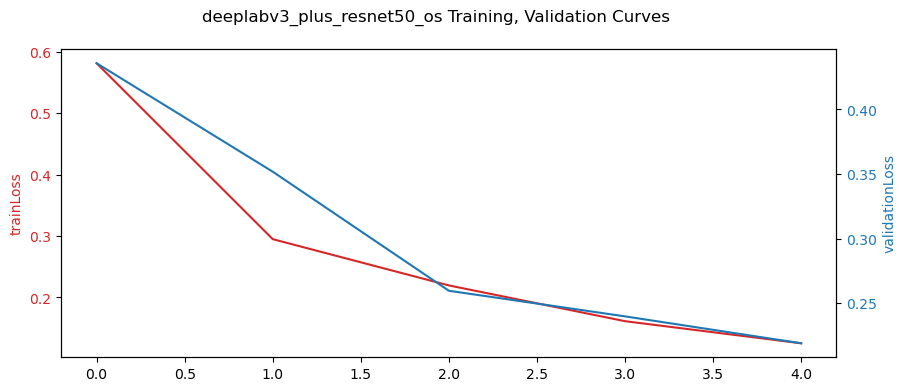

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# MODEL HYPERPARAMETERS
N_EPOCHS = 5
NUM_CLASSES = 3
MAX_LR = 3e-4
MODEL_NAME = 'deeplabv3_plus_resnet50_os'

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
criterion = smp.losses.DiceLoss('multiclass', classes=[0,1,2], log_loss = True, smooth=1.0)

# create model, optimizer, lr_scheduler and pass to training function
model = deeplabv3_plus(in_channels=3, output_stride=8, num_classes=NUM_CLASSES).to(device)
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader),
                       pct_start=0.3, div_factor=10, anneal_strategy='cos')

_ = train_validate_model(model, N_EPOCHS, MODEL_NAME, criterion, optimizer,
                         device, train_dataloader, val_dataloader, meanIoU, 'meanIoU',
                         NUM_CLASSES, lr_scheduler = scheduler, output_path = output_path)

## 4. Evaluate : Evaluate the model on Test Data and visualize results

In [17]:
model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))
_, test_metric = evaluate_model(model, test_dataloader, criterion, meanIoU, NUM_CLASSES, device)
print(f"\nModel has {test_metric} mean IoU in test set")

/tmp/ipykernel_3542657/463659770.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{output_path}/{MODEL_NAME}.pt', map_location=device))


Model has 0.761514849532459 mean IoU in test set


In [ ]:
from utils import visualize_predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


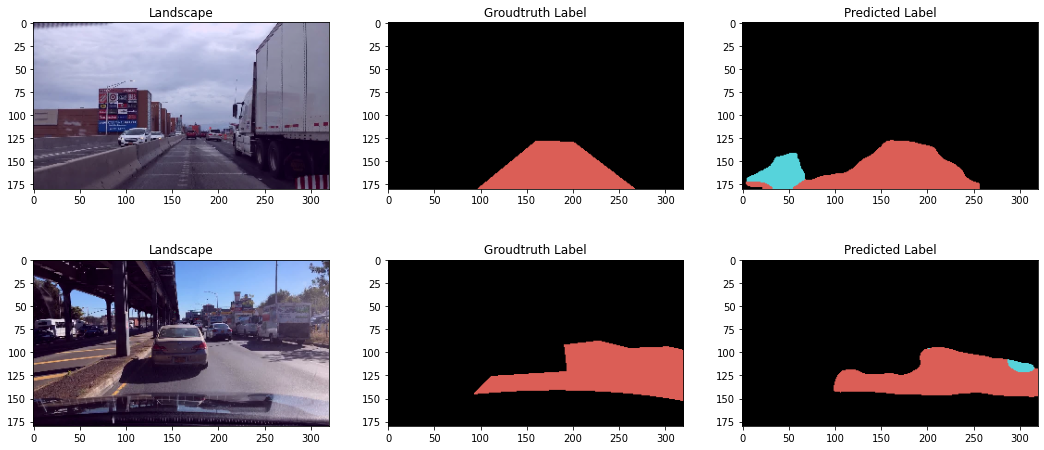

In [ ]:
num_test_samples = 2
_, axes = plt.subplots(num_test_samples, 3, figsize=(3*6, num_test_samples * 4))
visualize_predictions(model, test_set, axes, device, numTestSamples=num_test_samples, id_to_color=train_id_to_color)

## Test on sample video
If you want to test it on a real video, you can try:

```python
from utils import predict_video
predict_video(model, model_name, input_video_path, output_dir,
            target_width, target_height, device)
```

In out case, we'll have several videos we can try our model on:
* Highway (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi`
* Residential (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/residential_1242_375.avi`
* Campus (KITTI)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/campus_1224_370.avi`
* Stuttgart (Cityscapes)<p>
`!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/stuttgart_1024_512.avi`


In [ ]:
!wget https://thinkautonomous-segmentation.s3.eu-west-3.amazonaws.com/highway_1241_376.avi

In [19]:
from utils import predict_video
predict_video(model, "deeplabv3_plus_resnet50", "./../dataset/highway_1241_376.avi", "segmentation", 1241, 376, "cuda", train_id_to_color)

  0%|          | 0/1170 [00:00<?, ?it/s]

100%|██████████| 1170/1170 [00:57<00:00, 20.22it/s]
